<a href="https://colab.research.google.com/github/leyli16/HousingPricePrediction/blob/main/final_project_merged.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1.Introduction

We aim to study how property-level housing prices are influenced by structural attributes (e.g., house size, number of beds/baths) and external risk-related features such as environmental hazards and regional demographics.
Our goal is to build interpretable models that explain housing price variations across regions, identifying the key factors that contribute to higher or lower prices.
This project explores how housing prices are shaped by both property characteristics—such as square footage, number of bedrooms, and lot size—and external risk factors like natural disasters and regional demographics. By combining individual-level housing data with environmental and geographic context, we aim to provide more localized, data-driven insights that can help inform homebuyers, investors, and policymakers.


## 1.1 Import package

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import os
import kagglehub
import plotly.io as pio
from string import ascii_letters
import datetime as dt
import requests
from lxml import html
import math
import json
import re
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore")
from sklearn.neural_network import MLPRegressor
from sklearn.cluster import KMeans
from collections import Counter

# 2.USA Real Estate Data Wrangling, Cleaning, and EDA

## 2.1 Loading in USA Real Estate Dataset


In [2]:
# Download latest version
path = kagglehub.dataset_download("ahmedshahriarsakib/usa-real-estate-dataset")

print("Path to dataset files:", path)

100%|██████████| 38.2M/38.2M [00:00<00:00, 62.8MB/s]


Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/ahmedshahriarsakib/usa-real-estate-dataset/versions/25


In [3]:
files = os.listdir(path)
print("Files in dataset:", files)

Files in dataset: ['realtor-data.zip.csv']


In [4]:
file_path = os.path.join(path, 'realtor-data.zip.csv')
df_raw = pd.read_csv(file_path)

In [5]:
df_raw.head(10)

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,103378.0,for_sale,105000.0,3.0,2.0,0.12,1962661.0,Adjuntas,Puerto Rico,601.0,920.0,NaN
1,52707.0,for_sale,80000.0,4.0,2.0,0.08,1902874.0,Adjuntas,Puerto Rico,601.0,1527.0,NaN
2,103379.0,for_sale,67000.0,2.0,1.0,0.15,1404990.0,Juana Diaz,Puerto Rico,795.0,748.0,NaN
3,31239.0,for_sale,145000.0,4.0,2.0,0.10,1947675.0,Ponce,Puerto Rico,731.0,1800.0,NaN
4,34632.0,for_sale,65000.0,6.0,2.0,0.05,331151.0,Mayaguez,Puerto Rico,680.0,NaN,NaN
5,103378.0,for_sale,179000.0,4.0,3.0,0.46,1850806.0,San Sebastian,Puerto Rico,612.0,2520.0,NaN
6,1205.0,for_sale,50000.0,3.0,1.0,0.20,1298094.0,Ciales,Puerto Rico,639.0,2040.0,NaN
7,50739.0,for_sale,71600.0,3.0,2.0,0.08,1048466.0,Ponce,Puerto Rico,731.0,1050.0,NaN
8,81909.0,for_sale,100000.0,2.0,1.0,0.09,734904.0,Ponce,Puerto Rico,730.0,1092.0,NaN
9,65672.0,for_sale,300000.0,5.0,3.0,7.46,1946226.0,Las Marias,Puerto Rico,670.0,5403.0,NaN


In [6]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2226382 entries, 0 to 2226381
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   brokered_by     float64
 1   status          object 
 2   price           float64
 3   bed             float64
 4   bath            float64
 5   acre_lot        float64
 6   street          float64
 7   city            object 
 8   state           object 
 9   zip_code        float64
 10  house_size      float64
 11  prev_sold_date  object 
dtypes: float64(8), object(4)
memory usage: 203.8+ MB


In [7]:
df_raw.describe()

,brokered_by,price,bed,bath,acre_lot,street,zip_code,house_size
count,2.221849e+06,2.224841e+06,1.745065e+06,1.714611e+06,1.900793e+06,2.215516e+06,2.226083e+06,1.657898e+06
mean,5.293989e+04,5.241955e+05,3.275841e+00,2.496440e+00,1.522303e+01,1.012325e+06,5.218668e+04,2.714471e+03
std,3.064275e+04,2.138893e+06,1.567274e+00,1.652573e+00,7.628238e+02,5.837635e+05,2.895408e+04,8.081635e+05
min,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
25%,2.386100e+04,1.650000e+05,3.000000e+00,2.000000e+00,1.500000e-01,5.063128e+05,2.961700e+04,1.300000e+03
50%,5.288400e+04,3.250000e+05,3.000000e+00,2.000000e+00,2.600000e-01,1.012766e+06,4.838200e+04,1.760000e+03
75%,7.918300e+04,5.500000e+05,4.000000e+00,3.000000e+00,9.800000e-01,1.521173e+06,7.807000e+04,2.413000e+03
max,1.101420e+05,2.147484e+09,4.730000e+02,8.300000e+02,1.000000e+05,2.001357e+06,9.999900e+04,1.040400e+09


In [8]:
df_raw.describe(include = 'object')

,status,city,state,prev_sold_date
count,2226382,2224975,2226374,1492085
unique,3,20098,55,14954
top,for_sale,Houston,Florida,2022-03-31
freq,1389306,23862,249432,17171


## 2.2 Cleaning up USA Real Estate data

### Duplicates checking

In [9]:
df_raw.duplicated().sum()

np.int64(0)

### Column Filtering

In [10]:
# Keep only the necessary columns
df_req_cols = df_raw [['price', 'bed', 'bath', 'acre_lot', 'city', 'state', 'zip_code', 'house_size', 'status']]

### Drop nulls

In [11]:
total_missing = df_req_cols.isna().sum()*100/len(df_req_cols)
print('Percentage Missing Value %')
total_missing

Percentage Missing Value %


,0
price,0.069215
bed,21.618797
bath,22.986666
acre_lot,14.624130
city,0.063197
state,0.000359
zip_code,0.013430
house_size,25.533983
status,0.000000


In [12]:
# Drop nulls, reset and drop the index
df_nadropped = df_req_cols.dropna().reset_index(drop=True)
df_nadropped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1360347 entries, 0 to 1360346
Data columns (total 9 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   price       1360347 non-null  float64
 1   bed         1360347 non-null  float64
 2   bath        1360347 non-null  float64
 3   acre_lot    1360347 non-null  float64
 4   city        1360347 non-null  object 
 5   state       1360347 non-null  object 
 6   zip_code    1360347 non-null  float64
 7   house_size  1360347 non-null  float64
 8   status      1360347 non-null  object 
dtypes: float64(6), object(3)
memory usage: 93.4+ MB


In [13]:
total_missing = df_nadropped.isna().sum()*100/len(df_nadropped)
print('Percentage Missing Value %')
total_missing

Percentage Missing Value %


,0
price,0.0
bed,0.0
bath,0.0
acre_lot,0.0
city,0.0
state,0.0
zip_code,0.0
house_size,0.0
status,0.0


### Data type casting

In [14]:
# cast date types
df_typed = df_nadropped.astype({'price': 'float', 'bed': 'int', 'bath': 'int', 'acre_lot': 'float', 'city':'str', 'state':'str', 'zip_code':'int', 'house_size': 'float'})

In [15]:
df_typed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1360347 entries, 0 to 1360346
Data columns (total 9 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   price       1360347 non-null  float64
 1   bed         1360347 non-null  int64  
 2   bath        1360347 non-null  int64  
 3   acre_lot    1360347 non-null  float64
 4   city        1360347 non-null  object 
 5   state       1360347 non-null  object 
 6   zip_code    1360347 non-null  int64  
 7   house_size  1360347 non-null  float64
 8   status      1360347 non-null  object 
dtypes: float64(3), int64(3), object(3)
memory usage: 93.4+ MB


### Filter listings with sold status only and add price_per_sqft column

In [16]:
# Filter rows with status = sold
df_sold = df_typed[df_typed['status'] == 'sold'].drop(columns=['status'])

In [17]:
df_sold.head()

,price,bed,bath,acre_lot,city,state,zip_code,house_size
750602,524900.0,3,2,0.09,Aguada,Puerto Rico,602,2200.0
750603,90000.0,3,2,0.08,Aguadilla,Puerto Rico,603,1421.0
750604,22500.0,2,1,0.32,Anasco,Puerto Rico,610,850.0
750605,168000.0,6,4,0.05,Anasco,Puerto Rico,610,3422.0
750606,200000.0,3,1,4.98,Arecibo,Puerto Rico,612,580.0


In [18]:
df_sold.info()

<class 'pandas.core.frame.DataFrame'>
Index: 609745 entries, 750602 to 1360346
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   price       609745 non-null  float64
 1   bed         609745 non-null  int64  
 2   bath        609745 non-null  int64  
 3   acre_lot    609745 non-null  float64
 4   city        609745 non-null  object 
 5   state       609745 non-null  object 
 6   zip_code    609745 non-null  int64  
 7   house_size  609745 non-null  float64
dtypes: float64(3), int64(3), object(2)
memory usage: 41.9+ MB


### Remove outliers for USA Real Estate data

In [19]:
# IQR Method to remove outliers
# Define function for IQR filtering
def remove_outliers_iqr(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df
columns = ['price', 'bed', 'bath', 'acre_lot', 'house_size']
# Apply to the columns
df_sold_outlier_removed = remove_outliers_iqr(df_sold, columns)

In [20]:
df_sold_outlier_removed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 449027 entries, 750602 to 1360345
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   price       449027 non-null  float64
 1   bed         449027 non-null  int64  
 2   bath        449027 non-null  int64  
 3   acre_lot    449027 non-null  float64
 4   city        449027 non-null  object 
 5   state       449027 non-null  object 
 6   zip_code    449027 non-null  int64  
 7   house_size  449027 non-null  float64
dtypes: float64(3), int64(3), object(2)
memory usage: 30.8+ MB


### USA Real Estate data cleaned

In [21]:
# save the cleaned df to df_real_estate
df_real_estate = df_sold_outlier_removed

In [22]:
df_real_estate.describe()

,price,bed,bath,acre_lot,zip_code,house_size
count,4.490270e+05,449027.000000,449027.000000,449027.000000,449027.000000,449027.000000
mean,3.821518e+05,3.173598,2.247671,0.200624,57593.322001,1731.338002
std,2.182448e+05,0.751535,0.772791,0.126210,30128.125107,585.856441
min,1.000000e+00,2.000000,1.000000,0.000000,602.000000,100.000000
25%,2.249000e+05,3.000000,2.000000,0.120000,30339.000000,1286.000000
50%,3.390000e+05,3.000000,2.000000,0.170000,60631.000000,1638.000000
75%,4.985435e+05,4.000000,3.000000,0.250000,85388.000000,2094.000000
max,1.117000e+06,5.000000,4.000000,0.670000,99403.000000,3418.000000


## 2.3 Visualization

### Distribution of house price by number of beds

In [ ]:
sns.boxplot(x='bed', y='price', data=df_real_estate)
plt.title('Price by Number of Bedrooms')
plt.show()

In [ ]:
# Distributation of house price by number of beds
fig = px.histogram(df_real_estate, x="price", color="bed", nbins=20)
fig.update_layout(title="Distribution of House Price by Bed", xaxis_title="Price", yaxis_title="Count")
fig.show()

### Distribution of house price by number of bathrooms

In [ ]:
sns.boxplot(x='bath', y='price', data=df_real_estate)
plt.title('Price by Number of Bathrooms')
plt.show()

In [ ]:
# Distribution of house price by number of baths
fig = px.histogram(df_real_estate, x="price", color="bath", nbins=20)
fig.update_layout(title="Distribution of House Price by Bath", xaxis_title="Price", yaxis_title="Count")
fig.show()

### Distribution of house price by state

In [ ]:
fig = px.bar(df_real_estate.groupby(["state"])['price'].mean().reset_index(),
             x='state', y='price',width=700)
fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'},
                 title="Distribution of house price by state.")
fig.update_xaxes(type="category",tickangle=-70)
fig.show()

In [ ]:
# Sort states by median price
state_order = df_real_estate.groupby('state')['price'].median().sort_values(ascending=False).index.tolist()

# Plot with custom sort order
fig = px.box(df_real_estate, x='state', y='price', category_orders={'state': state_order},
             points=False, title='House Price Distribution by State (Sorted)',
             width=600, height=400)
fig.update_layout(xaxis_title='State', yaxis_title='Price', xaxis_tickangle=-45)
fig.show()

## 2.4 Loading in Zip code to County Dataset

In [29]:
# Download latest version
path = kagglehub.dataset_download("danofer/zipcodes-county-fips-crosswalk")

print("Path to dataset files:", path)

100%|██████████| 184k/184k [00:00<00:00, 55.9MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/danofer/zipcodes-county-fips-crosswalk/versions/1


In [30]:
files = os.listdir(path)
print("Files in dataset:", files)

Files in dataset: ['ZIP-COUNTY-FIPS_2017-06.csv']


In [31]:
file_path = os.path.join(path, 'ZIP-COUNTY-FIPS_2017-06.csv')
zip_county_df_raw = pd.read_csv(file_path)

In [32]:
zip_county_df_raw.head(10)

,ZIP,COUNTYNAME,STATE,STCOUNTYFP,CLASSFP
0,36003,Autauga County,AL,1001,H1
1,36006,Autauga County,AL,1001,H1
2,36067,Autauga County,AL,1001,H1
3,36066,Autauga County,AL,1001,H1
4,36703,Autauga County,AL,1001,H1
5,36701,Autauga County,AL,1001,H1
6,36091,Autauga County,AL,1001,H1
7,36051,Autauga County,AL,1001,H1
8,36068,Autauga County,AL,1001,H1
9,36008,Autauga County,AL,1001,H1


In [33]:
zip_county_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52889 entries, 0 to 52888
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ZIP         52889 non-null  int64 
 1   COUNTYNAME  52889 non-null  object
 2   STATE       52889 non-null  object
 3   STCOUNTYFP  52889 non-null  int64 
 4   CLASSFP     52889 non-null  object
dtypes: int64(2), object(3)
memory usage: 2.0+ MB


## 2.5 Cleaning up Zip Code to County Dataset

### Duplicates and null checking

In [34]:
zip_county_df_raw.duplicated().sum()

np.int64(0)

In [35]:
total_missing = zip_county_df_raw.isna().sum() * 100 / len(zip_county_df_raw)
print('Percentage Missing Value %')
total_missing

Percentage Missing Value %


,0
ZIP,0.0
COUNTYNAME,0.0
STATE,0.0
STCOUNTYFP,0.0
CLASSFP,0.0


### Data type casting

In [36]:
# cast date types
zip_county_df = zip_county_df_raw.astype({'ZIP': 'int', 'COUNTYNAME':'str', 'STATE':'str'})

In [37]:
zip_county_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52889 entries, 0 to 52888
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ZIP         52889 non-null  int64 
 1   COUNTYNAME  52889 non-null  object
 2   STATE       52889 non-null  object
 3   STCOUNTYFP  52889 non-null  int64 
 4   CLASSFP     52889 non-null  object
dtypes: int64(2), object(3)
memory usage: 2.0+ MB


### Column renaming

In [38]:
zip_county_df.rename(columns={'ZIP': 'zip_code', 'COUNTYNAME':'county', 'STATE':'state'}, inplace=True)

### Column Filtering

In [39]:
zip_county_df.drop(columns=['STCOUNTYFP', 'CLASSFP'], inplace=True)

### Row Filtering

In [40]:
# count unique counties per ZIP code
zip_counts = zip_county_df['zip_code'].value_counts()

# Step 1: Find ZIP codes with only one county
zips_one_county = zip_counts[zip_counts == 1].index
# Step 2: Filter out rows with those ZIP codes
zip_county_df = zip_county_df[zip_county_df['zip_code'].isin(zips_one_county)]

In [41]:
zip_county_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29102 entries, 0 to 52888
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   zip_code  29102 non-null  int64 
 1   county    29102 non-null  object
 2   state     29102 non-null  object
dtypes: int64(1), object(2)
memory usage: 909.4+ KB


## 2.6 Create new column "county" in USA Real Estate Dataset

In [42]:
# Merge df with zip_county_df to get county info
real_estate_df = pd.merge(df_real_estate, zip_county_df, on='zip_code', how='inner')
real_estate_df.drop(columns=['state_x'], inplace=True)
real_estate_df.rename(columns={'state_y':'state'},inplace=True)
real_estate_df.head(10)

,price,bed,bath,acre_lot,city,zip_code,house_size,county,state
0,22500.0,2,1,0.32,Anasco,610,850.0,Anasco Municipio,PR
1,120000.0,4,2,0.18,Sabana Grande,637,1188.0,Sabana Grande Municipio,PR
2,133000.0,3,1,0.60,Hatillo,659,1049.0,Hatillo Municipio,PR
3,220000.0,5,3,0.11,Isabela,662,2992.0,Isabela Municipio,PR
4,175000.0,3,3,0.45,Las Marias,670,3090.0,Las Marias Municipio,PR
5,149000.0,3,2,0.28,Mayaguez,682,2000.0,Mayaguez Municipio,PR
6,130000.0,3,2,0.07,Ponce,716,1024.0,Ponce Municipio,PR
7,140000.0,4,3,0.10,Naguabo,718,2222.0,Naguabo Municipio,PR
8,68900.0,3,1,0.09,Naguabo,718,900.0,Naguabo Municipio,PR
9,57900.0,3,1,0.24,Ponce,731,845.0,Ponce Municipio,PR


In [43]:
real_estate_df.shape

(338278, 9)

In [44]:
real_estate_df.describe()

,price,bed,bath,acre_lot,zip_code,house_size
count,3.382780e+05,338278.000000,338278.000000,338278.000000,338278.000000,338278.000000
mean,3.985179e+05,3.162272,2.236291,0.192204,59252.218084,1715.579503
std,2.228088e+05,0.754238,0.768575,0.121180,30860.386727,580.194862
min,1.000000e+00,2.000000,1.000000,0.000000,610.000000,100.000000
25%,2.350000e+05,3.000000,2.000000,0.120000,32505.000000,1275.000000
50%,3.500000e+05,3.000000,2.000000,0.170000,63301.000000,1622.000000
75%,5.200000e+05,4.000000,3.000000,0.240000,89439.000000,2071.000000
max,1.117000e+06,5.000000,4.000000,0.670000,99402.000000,3418.000000


In [45]:
real_estate_df.describe(include = 'object')

,city,county,state
count,338278,338278,338278
unique,6438,1147,50
top,Houston,Maricopa County,CA
freq,8452,13488,59085


## 2.7 Loading in Zip Code Demographics

In [46]:
# Download latest version
path = kagglehub.dataset_download("erdi28/zip-codes-demographics")

print("Path to dataset files:", path)

100%|██████████| 2.28M/2.28M [00:00<00:00, 117MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/erdi28/zip-codes-demographics/versions/3


In [47]:
files = os.listdir(path)
print("Files in dataset:", files)

Files in dataset: ['zip_code_demographics.csv']


In [48]:
file_path = os.path.join(path, 'zip_code_demographics.csv')
zip_code_demographics_df_raw = pd.read_csv(file_path)

In [49]:
zip_code_demographics_df_raw.head(10)

,zip,lat,lng,city,state_id,state_name,population,density,county_name,po_box,dist_highway,dist2_large_airport,dist2_medium_airport,dist_to_shore,number_of_business,adjusted_gross_income,total_income_amount,number_of_returns
0,1001,42.06262,-72.62521,Agawam,MA,Massachusetts,16088,550.1,Hampden,0,1.387035,106.145765,12.946212,93.049251,438.0,598807,6.047690e+05,9320
1,1002,42.37633,-72.46462,Amherst,MA,Massachusetts,27323,198.1,Hampshire,0,14.438177,112.264368,21.080079,133.370144,571.0,989558,1.005796e+06,9880
2,1005,42.42117,-72.10655,Barre,MA,Massachusetts,4947,44.2,Worcester,0,16.788339,90.664964,25.547718,97.639881,97.0,164207,1.660540e+05,2490
3,1007,42.28163,-72.40009,Belchertown,MA,Massachusetts,15304,107.7,Hampshire,0,13.663839,101.552921,14.762395,114.406034,217.0,647074,6.547390e+05,7970
4,1008,42.18234,-72.95819,Blandford,MA,Massachusetts,1171,7.4,Hampden,0,2.593655,136.548797,20.177950,107.466779,18.0,47826,4.824100e+04,660
5,1010,42.12904,-72.20597,Brimfield,MA,Massachusetts,3703,40.6,Hampden,0,4.737271,78.645500,28.049262,94.928024,73.0,155666,1.576770e+05,1980
6,1011,42.30233,-72.96448,Chester,MA,Massachusetts,1332,15.7,Hampden,0,8.058693,142.414627,26.041908,128.563170,13.0,38223,3.855300e+04,630
7,1012,42.38495,-72.84675,Chesterfield,MA,Massachusetts,503,16.1,Hampshire,0,18.331096,138.381684,27.466664,137.693285,10.0,24826,2.510200e+04,410
8,1013,42.16059,-72.60788,Chicopee,MA,Massachusetts,22709,1549.1,Hampden,0,0.062286,109.114246,7.075893,104.576258,317.0,516431,5.201740e+05,11270
9,1020,42.17618,-72.56538,Chicopee,MA,Massachusetts,30704,951.4,Hampden,0,0.925140,106.769095,3.205533,105.789421,550.0,828125,8.346140e+05,15760


In [50]:
zip_code_demographics_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33704 entries, 0 to 33703
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   zip                    33704 non-null  int64  
 1   lat                    33704 non-null  float64
 2   lng                    33704 non-null  float64
 3   city                   33704 non-null  object 
 4   state_id               33704 non-null  object 
 5   state_name             33704 non-null  object 
 6   population             33704 non-null  int64  
 7   density                33704 non-null  float64
 8   county_name            33704 non-null  object 
 9   po_box                 33704 non-null  int64  
 10  dist_highway           33704 non-null  float64
 11  dist2_large_airport    33704 non-null  float64
 12  dist2_medium_airport   33704 non-null  float64
 13  dist_to_shore          33704 non-null  float64
 14  number_of_business     33624 non-null  float64
 15  ad

In [51]:
zip_code_demographics_df_raw.describe()

,zip,lat,lng,population,density,po_box,dist_highway,dist2_large_airport,dist2_medium_airport,dist_to_shore,number_of_business,adjusted_gross_income,total_income_amount,number_of_returns
count,33704.000000,33704.000000,33704.000000,33704.000000,33704.000000,33704.000000,33704.000000,33704.000000,33704.000000,33704.000000,33624.000000,3.370400e+04,3.370400e+04,33704.000000
mean,49842.607821,38.888195,-91.051366,11287.959738,528.704068,0.179949,29.291294,158.648048,40.854624,304.798736,260.694920,4.251341e+05,4.298943e+05,5341.873665
std,27451.111442,5.228075,15.460095,15200.216997,2219.277025,0.384151,174.104869,166.207042,80.224956,298.948686,432.112814,7.561519e+05,7.644416e+05,7273.613660
min,1001.000000,-14.219840,-176.629620,0.000000,0.000000,0.000000,0.000194,0.112768,0.134153,0.011449,1.000000,5.770000e+02,5.770000e+02,90.000000
25%,27052.750000,35.427243,-97.255342,1253.750000,8.200000,0.000000,3.050420,59.434074,19.513217,61.286177,19.000000,3.247500e+04,3.287925e+04,580.000000
50%,49780.500000,39.502970,-88.224820,4099.000000,29.000000,0.000000,11.541912,125.957938,35.131017,207.328858,74.000000,1.128665e+05,1.140365e+05,1880.000000
75%,72210.250000,42.110000,-80.289333,16113.250000,238.825000,0.000000,30.046597,209.476362,55.231087,471.857289,334.000000,5.052290e+05,5.092270e+05,7560.000000
max,99929.000000,71.274340,144.876370,130352.000000,68424.500000,1.000000,10767.713382,6127.454722,5101.697518,1336.551268,7263.000000,1.522467e+07,1.527798e+07,61920.000000


In [52]:
zip_code_demographics_df_raw.describe(include = 'object')

,city,state_id,state_name,county_name
count,33704,33704,33704,33704
unique,17551,51,51,1800
top,Houston,TX,Texas,Washington
freq,106,1990,1990,401


## 2.8 Cleaning Zip Code Demographics Data

In [53]:
zip_code_demographics_df_raw.duplicated().sum()

np.int64(0)

In [54]:
# Keep only the necessary columns
zip_code_demographics_df = zip_code_demographics_df_raw [['zip', 'population', 'density', 'dist_highway', 'dist2_large_airport', 'dist_to_shore', 'number_of_business', 'adjusted_gross_income']]

In [55]:
total_missing = zip_code_demographics_df.isna().sum() * 100 / len(zip_code_demographics_df)
print('Percentage Missing Value %')
total_missing

Percentage Missing Value %


,0
zip,0.000000
population,0.000000
density,0.000000
dist_highway,0.000000
dist2_large_airport,0.000000
dist_to_shore,0.000000
number_of_business,0.237361
adjusted_gross_income,0.000000


In [56]:
# Drop nulls
zip_code_demographics_df = zip_code_demographics_df.dropna()
# Reset and drop the index
zip_code_demographics_df = zip_code_demographics_df.reset_index(drop=True)

In [57]:
total_missing = zip_code_demographics_df.isna().sum() * 100 / len(zip_code_demographics_df)
print('Percentage Missing Value %')
total_missing

Percentage Missing Value %


,0
zip,0.0
population,0.0
density,0.0
dist_highway,0.0
dist2_large_airport,0.0
dist_to_shore,0.0
number_of_business,0.0
adjusted_gross_income,0.0


In [58]:
# cast date types
zip_code_demographics_df = zip_code_demographics_df.astype({'zip': 'int', 'population': 'float', 'density': 'float', 'dist_highway': 'float', 'dist2_large_airport': 'float', 'dist_to_shore': 'float', 'number_of_business': 'float', 'adjusted_gross_income': 'float'})

In [59]:
zip_code_demographics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33624 entries, 0 to 33623
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   zip                    33624 non-null  int64  
 1   population             33624 non-null  float64
 2   density                33624 non-null  float64
 3   dist_highway           33624 non-null  float64
 4   dist2_large_airport    33624 non-null  float64
 5   dist_to_shore          33624 non-null  float64
 6   number_of_business     33624 non-null  float64
 7   adjusted_gross_income  33624 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 2.1 MB


In [60]:
zip_code_demographics_df.rename(columns={'zip': 'zip_code',
                                         'density':'population_density',
                                         'dist_highway':'dist_to_highway',
                                         'dist2_large_airport':'dist_to_airport'}, inplace=True)

## 2.9 Merge real_estate_df with zip_code_demographics_df to add the zip code related features

In [61]:
real_estate_features_df = pd.merge(real_estate_df, zip_code_demographics_df, on='zip_code', how='inner')
real_estate_features_df.head(10)

,price,bed,bath,acre_lot,city,zip_code,house_size,county,state,population,population_density,dist_to_highway,dist_to_airport,dist_to_shore,number_of_business,adjusted_gross_income
0,215000.0,3,2,0.19,Chicopee,1020,1828.0,Hampden County,MA,30704.0,951.4,0.925140,106.769095,105.789421,550.0,828125.0
1,269900.0,2,1,0.46,South Hadley,1075,1312.0,Hampshire County,MA,18051.0,393.3,2.910859,112.181953,115.181126,297.0,697896.0
2,314900.0,5,2,0.28,Chicopee,1013,2219.0,Hampden County,MA,22709.0,1549.1,0.062286,109.114246,104.576258,317.0,516431.0
3,244999.0,4,1,0.23,Springfield,1104,1285.0,Hampden County,MA,23226.0,1714.0,0.645911,104.785728,101.063511,528.0,453300.0
4,399900.0,3,3,0.35,Easthampton,1027,1380.0,Hampshire County,MA,17708.0,168.5,9.873599,125.949999,124.367513,372.0,671249.0
5,198000.0,2,1,0.14,Holyoke,1040,768.0,Hampden County,MA,38480.0,702.0,0.598474,114.170265,111.173366,907.0,832429.0
6,299900.0,3,1,0.40,Easthampton,1027,1424.0,Hampshire County,MA,17708.0,168.5,9.873599,125.949999,124.367513,372.0,671249.0
7,279000.0,3,1,0.23,Ludlow,1056,1164.0,Hampden County,MA,21050.0,298.9,2.608102,99.921771,105.057502,412.0,747067.0
8,319900.0,3,1,0.41,Northampton,1062,864.0,Hampshire County,MA,9835.0,217.6,3.630387,122.235452,124.761768,191.0,639133.0
9,264900.0,3,2,0.40,Holyoke,1040,1776.0,Hampden County,MA,38480.0,702.0,0.598474,114.170265,111.173366,907.0,832429.0


In [62]:
real_estate_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338148 entries, 0 to 338147
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   price                  338148 non-null  float64
 1   bed                    338148 non-null  int64  
 2   bath                   338148 non-null  int64  
 3   acre_lot               338148 non-null  float64
 4   city                   338148 non-null  object 
 5   zip_code               338148 non-null  int64  
 6   house_size             338148 non-null  float64
 7   county                 338148 non-null  object 
 8   state                  338148 non-null  object 
 9   population             338148 non-null  float64
 10  population_density     338148 non-null  float64
 11  dist_to_highway        338148 non-null  float64
 12  dist_to_airport        338148 non-null  float64
 13  dist_to_shore          338148 non-null  float64
 14  number_of_business     338148 non-nu

In [63]:
real_estate_features_df.describe()

,price,bed,bath,acre_lot,zip_code,house_size,population,population_density,dist_to_highway,dist_to_airport,dist_to_shore,number_of_business,adjusted_gross_income
count,3.381480e+05,338148.000000,338148.000000,338148.000000,338148.000000,338148.000000,338148.000000,338148.000000,338148.000000,338148.000000,338148.000000,338148.000000,3.381480e+05
mean,3.985160e+05,3.162272,2.236263,0.192209,59261.692052,1715.619681,35183.865905,1205.825783,6.331339,78.152613,187.680797,678.352136,1.261296e+06
std,2.227892e+05,0.754211,0.768534,0.121162,30852.169233,580.190767,19180.403151,1350.849182,12.922188,103.741284,239.755605,468.528140,9.092380e+05
min,1.000000e+00,2.000000,1.000000,0.000000,1001.000000,100.000000,0.000000,0.000000,0.000283,0.424420,0.011449,1.000000,2.925000e+03
25%,2.350000e+05,3.000000,2.000000,0.120000,32506.000000,1275.000000,21670.000000,293.500000,1.328307,19.921847,20.759234,335.000000,6.438270e+05
50%,3.500000e+05,3.000000,2.000000,0.170000,63301.000000,1622.000000,33096.000000,867.800000,2.829334,36.951682,73.724405,586.000000,1.074226e+06
75%,5.200000e+05,4.000000,3.000000,0.240000,89439.000000,2071.000000,45792.000000,1695.200000,5.967586,92.247183,314.774612,916.000000,1.632569e+06
max,1.117000e+06,5.000000,4.000000,0.670000,99402.000000,3418.000000,130352.000000,49565.300000,299.940968,994.951376,1330.442647,7263.000000,1.207523e+07


In [64]:
real_estate_features_df.describe(include = 'object')

,city,county,state
count,338148,338148,338148
unique,6399,1126,48
top,Houston,Maricopa County,CA
freq,8452,13488,59048


## 2.10 Remove outliers

In [65]:
cols_to_check = ['population', 'population_density', 'dist_to_highway',
                 'dist_to_airport', 'dist_to_shore', 'number_of_business',
                 'adjusted_gross_income']

In [66]:
def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

real_estate_features_df = remove_outliers_iqr(real_estate_features_df, cols_to_check)

In [67]:
real_estate_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 227566 entries, 0 to 335515
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   price                  227566 non-null  float64
 1   bed                    227566 non-null  int64  
 2   bath                   227566 non-null  int64  
 3   acre_lot               227566 non-null  float64
 4   city                   227566 non-null  object 
 5   zip_code               227566 non-null  int64  
 6   house_size             227566 non-null  float64
 7   county                 227566 non-null  object 
 8   state                  227566 non-null  object 
 9   population             227566 non-null  float64
 10  population_density     227566 non-null  float64
 11  dist_to_highway        227566 non-null  float64
 12  dist_to_airport        227566 non-null  float64
 13  dist_to_shore          227566 non-null  float64
 14  number_of_business     227566 non-null  f

## 2.11 Influence of regional features on house price



*   The price ranges from 0 to $1.117M since we removed the outliers of the USA real estate dataframe.
*   There are vertical lines observed in the graph since houses from the same zip_code have the same regional features; we merged regional features dataframe with the main dataframe on zip_code.



In [ ]:


pio.templates.default = "plotly_white"

features = ['population', 'population_density', 'dist_to_highway', 'dist_to_airport',
            'dist_to_shore', 'number_of_business', 'adjusted_gross_income']

for feature in features:
    fig = px.scatter(
        real_estate_features_df,
        x=feature,
        y='price',
        trendline='ols',
        title=f'House Price vs {feature.replace("_", " ").title()}',
        labels={feature: feature.replace("_", " ").title(), 'price': 'House Price ($)'},
        opacity=0.6,
        width=700,
        height=450
    )

    # Make scatter points subtle
    fig.update_traces(marker=dict(size=5, color='lightgray'), selector=dict(mode='markers'))

    # Make trendline bold and obvious
    fig.update_traces(
        line=dict(color='red', width=4, dash='solid'),
        selector=dict(mode='lines')  # This targets the trendline
    )

    fig.update_layout(
        title_font_size=18,
        title_x=0.5,
        margin=dict(l=40, r=40, t=60, b=40),
        xaxis=dict(gridcolor='lightgray'),
        yaxis=dict(gridcolor='lightgray')
    )

    fig.show()


*   Features that have positive correlation with price:
  *   Population (more populated the area, higher the price)
  *   Population Density (more densly populated the area, higher the price)
  *   Number of bussinesses (more bussiness in the area, higher the price)
  *   Adjusted gross income (wealthier the region, higher the price)
  *   Distance to highway (Further from highway, higher the price)

*   Features that have negative correlation with price:
  *   Distance to airport (more accessible to airport, higher the price)
  *   Distance to shore (closer to the shore, higher the house price)







# 3.County Demographics Data Cleaning and Wrangling


## 3.1 Loading County Demogrphics Dataset

In [69]:
# Download latest version
path = kagglehub.dataset_download("glozab/county-level-us-demographic-data-1990-2020")

print("Path to dataset files:", path)

100%|██████████| 13.1M/13.1M [00:00<00:00, 174MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/glozab/county-level-us-demographic-data-1990-2020/versions/1


In [70]:
files = os.listdir(path)
print("Files in dataset:", files)

Files in dataset: ['county_demographics.csv']


In [71]:
file_path = os.path.join(path, 'county_demographics.csv')
county_demographics_df_raw = pd.read_csv(file_path)

print(county_demographics_df_raw.head())

   year  fips  population  w_population  b_population  o_population  \
0  1990  1025       27289         15579         11643            35   
1  1990  1031       40293         32869          6950           160   
2  1990  1041       13598         10068          3516            11   
3  1990  1053       35526         24377         10050          1045   
4  1990  1101      209537        119702         87856           415   

   nh_population  hi_population  na_population  male_population  ...  \
0          27196             93              0            13052  ...   
1          39831            462              0            19673  ...   
2          13576             22              0             6421  ...   
3          35378            148              0            17454  ...   
4         207933           1604              0            98854  ...   

   age9_population_ratio  age10_population_ratio  age11_population_ratio  \
0                0.06263                 0.05552                

## 3.2 County Demographics Dataset Cleaning

In [72]:
county_demographics_df_raw.dtypes

,0
year,int64
fips,int64
population,int64
w_population,int64
b_population,int64
o_population,int64
nh_population,int64
hi_population,int64
na_population,int64
male_population,int64


In [73]:
county_demographics_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97287 entries, 0 to 97286
Data columns (total 57 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   year                     97287 non-null  int64  
 1   fips                     97287 non-null  int64  
 2   population               97287 non-null  int64  
 3   w_population             97287 non-null  int64  
 4   b_population             97287 non-null  int64  
 5   o_population             97287 non-null  int64  
 6   nh_population            97287 non-null  int64  
 7   hi_population            97287 non-null  int64  
 8   na_population            97287 non-null  int64  
 9   male_population          97287 non-null  int64  
 10  female_population        97287 non-null  int64  
 11  age0_population          97287 non-null  int64  
 12  age1_population          97287 non-null  int64  
 13  age2_population          97287 non-null  int64  
 14  age3_population       

In [74]:
#check how many missing values are in each column
county_demographics_df_raw.isna().sum().sort_values(ascending=False)

,0
year,0
fips,0
population,0
w_population,0
b_population,0
o_population,0
nh_population,0
hi_population,0
na_population,0
male_population,0


In [75]:
# keep the necessary columns
county_demographics_df_raw = county_demographics_df_raw.drop(columns = ['population', 'female_population', 'male_population', 'w_population', 'b_population', 'o_population', 'nh_population', 'hi_population', 'na_population',
                                           'age0_population', 'age1_population', 'age2_population', 'age3_population', 'age4_population', 'age5_population',
                                           'age6_population', 'age7_population', 'age8_population', 'age9_population', 'age10_population', 'age11_population',
                                           'age12_population', 'age13_population', 'age14_population', 'age15_population', 'age16_population', 'age17_population',
                                           'age18_population'])

In [76]:
county_demographics_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97287 entries, 0 to 97286
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   year                     97287 non-null  int64  
 1   fips                     97287 non-null  int64  
 2   w_population_ratio       97287 non-null  float64
 3   b_population_ratio       97287 non-null  float64
 4   o_population_ratio       97287 non-null  float64
 5   nh_population_ratio      97287 non-null  float64
 6   hi_population_ratio      97287 non-null  float64
 7   na_population_ratio      97287 non-null  float64
 8   male_population_ratio    97287 non-null  float64
 9   female_population_ratio  97287 non-null  float64
 10  age0_population_ratio    97287 non-null  float64
 11  age1_population_ratio    97287 non-null  float64
 12  age2_population_ratio    97287 non-null  float64
 13  age3_population_ratio    97287 non-null  float64
 14  age4_population_ratio 

### Rename Columns for Consistency

In [77]:
county_demographics_df_raw.columns = county_demographics_df_raw.columns.str.strip().str.lower().str.replace(' ', '_')

In [78]:
# Rename age groups
county_demographics_df_renamed = county_demographics_df_raw
county_demographics_df_renamed.rename(
    columns=
     {
    'w_population_ratio': 'caucasion_population_ratio',
    'b_population_ratio': 'African-American_population_ratio',
    'o_population_ratio': 'other_race_population_ratio',
    'nh_population_ratio':'non-Hispanic_population_ratio',
    'hi_population_ratio':'hispanic_population_ratio',
    'na_population_ratio':'other_origin_population_ratio',
    'age0_population_ratio':'age_less_1_population_ratio',
    'age1_population_ratio':'age_1_to_4_population_ratio',
    'age2_population_ratio':'age_5_to_9_population_ratio',
    'age3_population_ratio':'age_10_to_14_population_ratio',
    'age4_population_ratio':'age_15_to_19_population_ratio',
    'age5_population_ratio':'age_20_to_24_population_ratio',
    'age6_population_ratio':'age_25_to_29_population_ratio',
    'age7_population_ratio':'age_30_to_34_population_ratio',
    'age8_population_ratio':'age_35_to_39_population_ratio',
    'age9_population_ratio':'age_40_to_44_population_ratio',
    'age10_population_ratio':'age_45_to_49_population_ratio',
    'age11_population_ratio':'age_50_to_54_population_ratio',
    'age12_population_ratio':'age_55_to_59_population_ratio',
    'age13_population_ratio':'age_60_to_64_population_ratio',
    'age14_population_ratio':'age_65_to_69_population_ratio',
    'age15_population_ratio':'age_70_to_74_population_ratio',
    'age16_population_ratio':'age_75_to_79_population_ratio',
    'age17_population_ratio':'age_80_to_84_population_ratio',
    'age18_population_ratio':'age_85_and_over_population_ratio'
    }, inplace=True)

In [79]:
county_demographics_df_renamed.reset_index(drop=True, inplace=True)

In [80]:
county_demographics_df_renamed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97287 entries, 0 to 97286
Data columns (total 29 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   year                               97287 non-null  int64  
 1   fips                               97287 non-null  int64  
 2   caucasion_population_ratio         97287 non-null  float64
 3   African-American_population_ratio  97287 non-null  float64
 4   other_race_population_ratio        97287 non-null  float64
 5   non-Hispanic_population_ratio      97287 non-null  float64
 6   hispanic_population_ratio          97287 non-null  float64
 7   other_origin_population_ratio      97287 non-null  float64
 8   male_population_ratio              97287 non-null  float64
 9   female_population_ratio            97287 non-null  float64
 10  age_less_1_population_ratio        97287 non-null  float64
 11  age_1_to_4_population_ratio        97287 non-null  flo

Grouping age group

In [81]:
county_demographics_df_renamed['age_0_to_19_population_ratio'] = county_demographics_df_renamed[[
    'age_less_1_population_ratio',
    'age_1_to_4_population_ratio',
    'age_5_to_9_population_ratio',
    'age_10_to_14_population_ratio',
    'age_15_to_19_population_ratio']].sum(axis=1)

In [82]:
county_demographics_df_renamed['age_20_to_39_population_ratio'] = county_demographics_df_renamed[[
    'age_20_to_24_population_ratio',
    'age_25_to_29_population_ratio',
    'age_30_to_34_population_ratio',
    'age_35_to_39_population_ratio']].sum(axis=1)

In [83]:
county_demographics_df_renamed['age_40_to_59_population_ratio'] = county_demographics_df_renamed[[
    'age_40_to_44_population_ratio',
    'age_45_to_49_population_ratio',
    'age_50_to_54_population_ratio',
    'age_55_to_59_population_ratio']].sum(axis=1)

In [84]:
county_demographics_df_renamed['age_60_to_79_population_ratio'] = county_demographics_df_renamed[[
    'age_60_to_64_population_ratio',
    'age_65_to_69_population_ratio',
    'age_70_to_74_population_ratio',
    'age_75_to_79_population_ratio']].sum(axis=1)

In [85]:
county_demographics_df_renamed['age_80_and_over_population_ratio'] = county_demographics_df_renamed[[
    'age_80_to_84_population_ratio',
    'age_85_and_over_population_ratio']].sum(axis=1)

In [86]:
county_demographics_grouped_df = county_demographics_df_renamed[['year',
                                                                 'fips',
                                                                 'caucasion_population_ratio',
                                                                 'African-American_population_ratio',
                                                                 'other_race_population_ratio',
                                                                 'non-Hispanic_population_ratio',
                                                                 'hispanic_population_ratio',
                                                                 'male_population_ratio',
                                                                 'female_population_ratio',
                                                                 'age_0_to_19_population_ratio',
                                                                 'age_20_to_39_population_ratio',
                                                                 'age_40_to_59_population_ratio',
                                                                 'age_60_to_79_population_ratio',
                                                                 'age_80_and_over_population_ratio'
                                                                ]]

In [87]:
county_demographics_grouped_df.head()

,year,fips,caucasion_population_ratio,African-American_population_ratio,other_race_population_ratio,non-Hispanic_population_ratio,hispanic_population_ratio,male_population_ratio,female_population_ratio,age_0_to_19_population_ratio,age_20_to_39_population_ratio,age_40_to_59_population_ratio,age_60_to_79_population_ratio,age_80_and_over_population_ratio
0,1990,1025,0.57089,0.42666,0.00128,0.99659,0.00341,0.47829,0.52171,0.33075,0.28386,0.21295,0.14083,0.03162
1,1990,1031,0.81575,0.17249,0.00397,0.98853,0.01147,0.48825,0.51175,0.28436,0.30236,0.23560,0.14849,0.02918
2,1990,1041,0.74040,0.25857,0.00081,0.99838,0.00162,0.47220,0.52780,0.29334,0.26210,0.21275,0.18886,0.04295
3,1990,1053,0.68617,0.28289,0.02942,0.99583,0.00417,0.49130,0.50870,0.29682,0.29283,0.22459,0.15266,0.03310
4,1990,1101,0.57127,0.41929,0.00198,0.99235,0.00765,0.47177,0.52823,0.30814,0.32970,0.20688,0.12899,0.02628


In [88]:
county_demographics_grouped_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97287 entries, 0 to 97286
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   year                               97287 non-null  int64  
 1   fips                               97287 non-null  int64  
 2   caucasion_population_ratio         97287 non-null  float64
 3   African-American_population_ratio  97287 non-null  float64
 4   other_race_population_ratio        97287 non-null  float64
 5   non-Hispanic_population_ratio      97287 non-null  float64
 6   hispanic_population_ratio          97287 non-null  float64
 7   male_population_ratio              97287 non-null  float64
 8   female_population_ratio            97287 non-null  float64
 9   age_0_to_19_population_ratio       97287 non-null  float64
 10  age_20_to_39_population_ratio      97287 non-null  float64
 11  age_40_to_59_population_ratio      97287 non-null  flo

 ### Handle Duplicates

In [89]:
county_demographics_df = county_demographics_grouped_df.drop_duplicates()
county_demographics_df = county_demographics_df.dropna()
county_demographics_df.head()

,year,fips,caucasion_population_ratio,African-American_population_ratio,other_race_population_ratio,non-Hispanic_population_ratio,hispanic_population_ratio,male_population_ratio,female_population_ratio,age_0_to_19_population_ratio,age_20_to_39_population_ratio,age_40_to_59_population_ratio,age_60_to_79_population_ratio,age_80_and_over_population_ratio
0,1990,1025,0.57089,0.42666,0.00128,0.99659,0.00341,0.47829,0.52171,0.33075,0.28386,0.21295,0.14083,0.03162
1,1990,1031,0.81575,0.17249,0.00397,0.98853,0.01147,0.48825,0.51175,0.28436,0.30236,0.23560,0.14849,0.02918
2,1990,1041,0.74040,0.25857,0.00081,0.99838,0.00162,0.47220,0.52780,0.29334,0.26210,0.21275,0.18886,0.04295
3,1990,1053,0.68617,0.28289,0.02942,0.99583,0.00417,0.49130,0.50870,0.29682,0.29283,0.22459,0.15266,0.03310
4,1990,1101,0.57127,0.41929,0.00198,0.99235,0.00765,0.47177,0.52823,0.30814,0.32970,0.20688,0.12899,0.02628


In [90]:
county_demographics_df.describe()

,year,fips,caucasion_population_ratio,African-American_population_ratio,other_race_population_ratio,non-Hispanic_population_ratio,hispanic_population_ratio,male_population_ratio,female_population_ratio,age_0_to_19_population_ratio,age_20_to_39_population_ratio,age_40_to_59_population_ratio,age_60_to_79_population_ratio,age_80_and_over_population_ratio
count,97287.000000,97287.000000,97287.000000,97287.000000,97287.000000,97287.000000,97287.000000,97287.000000,97287.000000,97287.000000,97287.000000,97287.000000,97287.000000,97287.000000
mean,2005.009436,30412.859950,0.873184,0.092728,0.021730,0.928248,0.071752,0.497252,0.502748,0.271176,0.252334,0.261087,0.173507,0.041897
std,8.942825,15147.842995,0.162454,0.146201,0.079129,0.127350,0.127350,0.020924,0.020924,0.039014,0.047064,0.032236,0.046070,0.015786
min,1990.000000,1001.000000,0.026820,0.000000,0.000000,0.022170,0.000000,0.426270,0.263150,0.000000,0.091950,0.071020,0.016920,0.000000
25%,1997.000000,18183.000000,0.831025,0.006920,0.002340,0.933745,0.010840,0.486570,0.497950,0.248120,0.221490,0.239750,0.142610,0.031370
50%,2005.000000,29179.000000,0.944570,0.023300,0.004520,0.975160,0.024840,0.493810,0.506190,0.270190,0.248140,0.262900,0.168900,0.039750
75%,2013.000000,45083.000000,0.979380,0.107380,0.010520,0.989160,0.066255,0.502050,0.513430,0.292315,0.278560,0.282740,0.199930,0.049880
max,2020.000000,99999.000000,1.000000,0.871530,0.971690,1.000000,0.977830,0.736850,0.573730,0.506840,0.576100,0.537630,0.556150,0.252870


## 3.3 Loading Fips Code DataSet




In [91]:
%%capture
!pip instsall kaggle
from google.colab import drive
drive.mount('/content/drive')

!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

In [92]:
# Loading county df data from google drive
fips_df = pd.read_csv('/content/drive/MyDrive/data_sets/state_and_county_fips_master.csv')

In [93]:
fips_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3195 entries, 0 to 3194
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   fips    3195 non-null   int64 
 1   name    3195 non-null   object
 2   state   3143 non-null   object
dtypes: int64(1), object(2)
memory usage: 75.0+ KB


In [94]:
fips_df.head()

,fips,name,state
0,0,UNITED STATES,NaN
1,1000,ALABAMA,NaN
2,1001,Autauga County,AL
3,1003,Baldwin County,AL
4,1005,Barbour County,AL


In [95]:
fips_df.describe()

,fips
count,3195.000000
mean,30358.079499
std,15181.225584
min,0.000000
25%,18172.000000
50%,29175.000000
75%,45076.000000
max,56045.000000


## 3.4 Merging the county_demographics_df with fips_df

In [96]:
county_demographics_merged_df = county_demographics_df.merge(
    fips_df,
    on='fips',
    how='left'
)
county_demographics_merged_df.head()

,year,fips,caucasion_population_ratio,African-American_population_ratio,other_race_population_ratio,non-Hispanic_population_ratio,hispanic_population_ratio,male_population_ratio,female_population_ratio,age_0_to_19_population_ratio,age_20_to_39_population_ratio,age_40_to_59_population_ratio,age_60_to_79_population_ratio,age_80_and_over_population_ratio,name,state
0,1990,1025,0.57089,0.42666,0.00128,0.99659,0.00341,0.47829,0.52171,0.33075,0.28386,0.21295,0.14083,0.03162,Clarke County,AL
1,1990,1031,0.81575,0.17249,0.00397,0.98853,0.01147,0.48825,0.51175,0.28436,0.30236,0.23560,0.14849,0.02918,Coffee County,AL
2,1990,1041,0.74040,0.25857,0.00081,0.99838,0.00162,0.47220,0.52780,0.29334,0.26210,0.21275,0.18886,0.04295,Crenshaw County,AL
3,1990,1053,0.68617,0.28289,0.02942,0.99583,0.00417,0.49130,0.50870,0.29682,0.29283,0.22459,0.15266,0.03310,Escambia County,AL
4,1990,1101,0.57127,0.41929,0.00198,0.99235,0.00765,0.47177,0.52823,0.30814,0.32970,0.20688,0.12899,0.02628,Montgomery County,AL


### Sanity Check After Merging

In [97]:
print(county_demographics_merged_df.columns)         # See all columns
print(county_demographics_merged_df[['fips', 'name']].head())  # Confirm correct matches
print(county_demographics_merged_df.isna().sum())    # Check for unmatched FIPS

Index(['year', 'fips', 'caucasion_population_ratio',
       'African-American_population_ratio', 'other_race_population_ratio',
       'non-Hispanic_population_ratio', 'hispanic_population_ratio',
       'male_population_ratio', 'female_population_ratio',
       'age_0_to_19_population_ratio', 'age_20_to_39_population_ratio',
       'age_40_to_59_population_ratio', 'age_60_to_79_population_ratio',
       'age_80_and_over_population_ratio', 'name', 'state'],
      dtype='object')
   fips               name
0  1025      Clarke County
1  1031      Coffee County
2  1041    Crenshaw County
3  1053    Escambia County
4  1101  Montgomery County
year                                   0
fips                                   0
caucasion_population_ratio             0
African-American_population_ratio      0
other_race_population_ratio            0
non-Hispanic_population_ratio          0
hispanic_population_ratio              0
male_population_ratio                  0
female_population_ratio   

## 3.5 Cleaning the Merged Data

Checking for unmatched FIPS — that output tells us 174 rows in the county_demographics_df didn't find a match in fips_df, because name, state, and any other info from fips_df came back as NaN.

In [98]:
unmatched = county_demographics_merged_df[county_demographics_merged_df['name'].isna()]
print(unmatched['fips'].unique()[:10])

[ 2910  4910 51917  8911  2201  8912  8913  2280  2232  2010]


In [99]:
county_demographics_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97287 entries, 0 to 97286
Data columns (total 16 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   year                               97287 non-null  int64  
 1   fips                               97287 non-null  int64  
 2   caucasion_population_ratio         97287 non-null  float64
 3   African-American_population_ratio  97287 non-null  float64
 4   other_race_population_ratio        97287 non-null  float64
 5   non-Hispanic_population_ratio      97287 non-null  float64
 6   hispanic_population_ratio          97287 non-null  float64
 7   male_population_ratio              97287 non-null  float64
 8   female_population_ratio            97287 non-null  float64
 9   age_0_to_19_population_ratio       97287 non-null  float64
 10  age_20_to_39_population_ratio      97287 non-null  float64
 11  age_40_to_59_population_ratio      97287 non-null  flo

Drop the unmatched rows.

In [100]:
county_demographics_merged_df = county_demographics_merged_df[county_demographics_merged_df['name'].notna()].reset_index(drop=True)
county_demographics_merged_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97113 entries, 0 to 97112
Data columns (total 16 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   year                               97113 non-null  int64  
 1   fips                               97113 non-null  int64  
 2   caucasion_population_ratio         97113 non-null  float64
 3   African-American_population_ratio  97113 non-null  float64
 4   other_race_population_ratio        97113 non-null  float64
 5   non-Hispanic_population_ratio      97113 non-null  float64
 6   hispanic_population_ratio          97113 non-null  float64
 7   male_population_ratio              97113 non-null  float64
 8   female_population_ratio            97113 non-null  float64
 9   age_0_to_19_population_ratio       97113 non-null  float64
 10  age_20_to_39_population_ratio      97113 non-null  float64
 11  age_40_to_59_population_ratio      97113 non-null  flo

In [101]:
county_demographics_merged_df = county_demographics_merged_df.rename(columns={'name': 'county'})
county_demographics_merged_df = county_demographics_merged_df.dropna()
county_demographics_merged_df = county_demographics_merged_df.drop_duplicates()
county_demographics_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97113 entries, 0 to 97112
Data columns (total 16 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   year                               97113 non-null  int64  
 1   fips                               97113 non-null  int64  
 2   caucasion_population_ratio         97113 non-null  float64
 3   African-American_population_ratio  97113 non-null  float64
 4   other_race_population_ratio        97113 non-null  float64
 5   non-Hispanic_population_ratio      97113 non-null  float64
 6   hispanic_population_ratio          97113 non-null  float64
 7   male_population_ratio              97113 non-null  float64
 8   female_population_ratio            97113 non-null  float64
 9   age_0_to_19_population_ratio       97113 non-null  float64
 10  age_20_to_39_population_ratio      97113 non-null  float64
 11  age_40_to_59_population_ratio      97113 non-null  flo

## 3.6 Result of county demographics df from year 1990 to 2020

In [102]:
county_demographics_merged_df.head()

,year,fips,caucasion_population_ratio,African-American_population_ratio,other_race_population_ratio,non-Hispanic_population_ratio,hispanic_population_ratio,male_population_ratio,female_population_ratio,age_0_to_19_population_ratio,age_20_to_39_population_ratio,age_40_to_59_population_ratio,age_60_to_79_population_ratio,age_80_and_over_population_ratio,county,state
0,1990,1025,0.57089,0.42666,0.00128,0.99659,0.00341,0.47829,0.52171,0.33075,0.28386,0.21295,0.14083,0.03162,Clarke County,AL
1,1990,1031,0.81575,0.17249,0.00397,0.98853,0.01147,0.48825,0.51175,0.28436,0.30236,0.23560,0.14849,0.02918,Coffee County,AL
2,1990,1041,0.74040,0.25857,0.00081,0.99838,0.00162,0.47220,0.52780,0.29334,0.26210,0.21275,0.18886,0.04295,Crenshaw County,AL
3,1990,1053,0.68617,0.28289,0.02942,0.99583,0.00417,0.49130,0.50870,0.29682,0.29283,0.22459,0.15266,0.03310,Escambia County,AL
4,1990,1101,0.57127,0.41929,0.00198,0.99235,0.00765,0.47177,0.52823,0.30814,0.32970,0.20688,0.12899,0.02628,Montgomery County,AL


##3.7 Result of county demographics df for year 2020 alone, used for housing price static anaylsis

In [103]:
# filter demographics data for year of 2020 for static analysis portion
county_demographics_2020_df = county_demographics_merged_df[county_demographics_merged_df['year'] == 2020].reset_index(drop=True)
county_demographics_2020_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3141 entries, 0 to 3140
Data columns (total 16 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   year                               3141 non-null   int64  
 1   fips                               3141 non-null   int64  
 2   caucasion_population_ratio         3141 non-null   float64
 3   African-American_population_ratio  3141 non-null   float64
 4   other_race_population_ratio        3141 non-null   float64
 5   non-Hispanic_population_ratio      3141 non-null   float64
 6   hispanic_population_ratio          3141 non-null   float64
 7   male_population_ratio              3141 non-null   float64
 8   female_population_ratio            3141 non-null   float64
 9   age_0_to_19_population_ratio       3141 non-null   float64
 10  age_20_to_39_population_ratio      3141 non-null   float64
 11  age_40_to_59_population_ratio      3141 non-null   float

## 3.8 Merge with real_estate_features_df to add the new features

In [104]:
# Merge with real_estate_features_df
real_estate_df = pd.merge(real_estate_features_df, county_demographics_2020_df, on=['county','state'], how='inner')
real_estate_df.head()

,price,bed,bath,acre_lot,city,zip_code,house_size,county,state,population,...,other_race_population_ratio,non-Hispanic_population_ratio,hispanic_population_ratio,male_population_ratio,female_population_ratio,age_0_to_19_population_ratio,age_20_to_39_population_ratio,age_40_to_59_population_ratio,age_60_to_79_population_ratio,age_80_and_over_population_ratio
0,215000.0,3,2,0.19,Chicopee,1020,1828.0,Hampden County,MA,30704.0,...,0.00926,0.73248,0.26752,0.48298,0.51702,0.24032,0.26673,0.24718,0.20154,0.04424
1,269900.0,2,1,0.46,South Hadley,1075,1312.0,Hampshire County,MA,18051.0,...,0.00380,0.93769,0.06231,0.46567,0.53433,0.22457,0.30568,0.21829,0.21032,0.04114
2,314900.0,5,2,0.28,Chicopee,1013,2219.0,Hampden County,MA,22709.0,...,0.00926,0.73248,0.26752,0.48298,0.51702,0.24032,0.26673,0.24718,0.20154,0.04424
3,244999.0,4,1,0.23,Springfield,1104,1285.0,Hampden County,MA,23226.0,...,0.00926,0.73248,0.26752,0.48298,0.51702,0.24032,0.26673,0.24718,0.20154,0.04424
4,399900.0,3,3,0.35,Easthampton,1027,1380.0,Hampshire County,MA,17708.0,...,0.00380,0.93769,0.06231,0.46567,0.53433,0.22457,0.30568,0.21829,0.21032,0.04114


In [105]:
# drop year and fips column for static analysis portion
real_estate_df = real_estate_df.drop(columns=['year', 'fips'])

In [106]:
real_estate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227566 entries, 0 to 227565
Data columns (total 28 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   price                              227566 non-null  float64
 1   bed                                227566 non-null  int64  
 2   bath                               227566 non-null  int64  
 3   acre_lot                           227566 non-null  float64
 4   city                               227566 non-null  object 
 5   zip_code                           227566 non-null  int64  
 6   house_size                         227566 non-null  float64
 7   county                             227566 non-null  object 
 8   state                              227566 non-null  object 
 9   population                         227566 non-null  float64
 10  population_density                 227566 non-null  float64
 11  dist_to_highway                    2275

### Remove outliers for the new features

### Removed outliers for the new features to decrease the scewness of the data

In [107]:
cols_to_check = ['caucasion_population_ratio', 'African-American_population_ratio',
                 'other_race_population_ratio', 'non-Hispanic_population_ratio',
                 'hispanic_population_ratio', 'male_population_ratio',
                 'female_population_ratio','age_0_to_19_population_ratio',
                 'age_20_to_39_population_ratio', 'age_40_to_59_population_ratio',
                 'age_60_to_79_population_ratio', 'age_80_and_over_population_ratio'
                 ]


In [108]:
def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

real_estate_df = remove_outliers_iqr(real_estate_df, cols_to_check)

In [109]:
real_estate_df.describe()

,price,bed,bath,acre_lot,zip_code,house_size,population,population_density,dist_to_highway,dist_to_airport,...,other_race_population_ratio,non-Hispanic_population_ratio,hispanic_population_ratio,male_population_ratio,female_population_ratio,age_0_to_19_population_ratio,age_20_to_39_population_ratio,age_40_to_59_population_ratio,age_60_to_79_population_ratio,age_80_and_over_population_ratio
count,1.878470e+05,187847.000000,187847.000000,187847.000000,187847.000000,187847.000000,187847.000000,187847.000000,187847.000000,187847.000000,...,187847.000000,187847.000000,187847.000000,187847.000000,187847.000000,187847.000000,187847.000000,187847.000000,187847.000000,187847.000000
mean,4.112225e+05,3.195649,2.247867,0.185990,59640.072905,1730.532982,35141.969486,1227.971677,3.085725,39.910852,...,0.012552,0.775711,0.224289,0.491907,0.508093,0.250916,0.277074,0.254180,0.181304,0.036527
std,2.208957e+05,0.751064,0.781625,0.116321,32080.062008,581.615761,16283.928829,870.113888,2.735314,33.161064,...,0.008195,0.153295,0.153295,0.006546,0.006546,0.021860,0.024942,0.011908,0.025497,0.008505
min,1.000000e+00,2.000000,1.000000,0.000000,1001.000000,123.000000,74.000000,2.400000,0.001774,1.203462,...,0.001570,0.390580,0.008170,0.475080,0.491710,0.192680,0.198020,0.220350,0.134280,0.019910
25%,2.490000e+05,3.000000,2.000000,0.110000,30008.000000,1288.000000,23364.000000,494.700000,1.105146,17.152680,...,0.005840,0.684830,0.086150,0.488480,0.504060,0.235770,0.256080,0.244870,0.166290,0.030870
50%,3.750000e+05,3.000000,2.000000,0.160000,63304.000000,1636.000000,34084.000000,1082.400000,2.249961,29.591821,...,0.010610,0.778080,0.221920,0.492950,0.507050,0.245180,0.277590,0.250960,0.178090,0.036850
75%,5.399000e+05,4.000000,3.000000,0.230000,92021.000000,2091.000000,45429.000000,1799.000000,4.068561,50.052820,...,0.017300,0.913850,0.315170,0.495940,0.511520,0.263070,0.297790,0.262440,0.201100,0.042020
max,1.117000e+06,5.000000,4.000000,0.670000,98686.000000,3418.000000,81156.000000,3766.800000,13.421442,179.595101,...,0.032460,0.991830,0.609420,0.508290,0.524920,0.305900,0.353800,0.287150,0.262170,0.059790


In [110]:
real_estate_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 187847 entries, 0 to 227458
Data columns (total 28 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   price                              187847 non-null  float64
 1   bed                                187847 non-null  int64  
 2   bath                               187847 non-null  int64  
 3   acre_lot                           187847 non-null  float64
 4   city                               187847 non-null  object 
 5   zip_code                           187847 non-null  int64  
 6   house_size                         187847 non-null  float64
 7   county                             187847 non-null  object 
 8   state                              187847 non-null  object 
 9   population                         187847 non-null  float64
 10  population_density                 187847 non-null  float64
 11  dist_to_highway                    187847 no

## 3.9 Visualization

### Correlation Heatmap

In [ ]:
# Correlation heatmap
plt.figure(figsize=(28, 26))
sns.heatmap(real_estate_df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

Some observations:
* Price correlation highlights: For the first column of the heatmap (correlation with price):
All the features do not have |R| > 0.7, which suggests they do not have a strong correlation with housing price. However, we can observe some positive and negative correlation with housing price as follows:
* Notable positive correlation:
  * adjusted_gross_income: Highest positve correlation — richer areas → higher home prices
  * bed: More bedrooms → higher home prices
  * bath: More bathrooms → higher home prices
  * zip_code
  * population density: More densly populated area → higher home prices
  * number of bussiness: More number of bussinesses → higher home prices
  * age_20_to_39_population_ratio: More working age population → higher home prices
  * age_40_to_59_populatiom_ratio: More middle age population → higher home prices
* Notable Negative correlations:
  * dist_to_shore: Closer from coast → higher home prices
  * dist_to_airport: More accessible to highway → higher home prices
  * age_60_to_79_population_ratio: More elderly population → less home prices
  * age_80_and_over_population_ratio: More elderly population → less home prices

Other features don't seem to be highly correlated with home prices


### Population Distribution by Racial Group

In [ ]:
df = real_estate_df.copy()
# Normalize race ratios to sum to 1 per row (to simulate real proportions)
total_ratios = df[['caucasion_population_ratio', 'African-American_population_ratio',
                   'hispanic_population_ratio', 'other_race_population_ratio']].sum(axis=1)
df['caucasion_population_ratio'] /= total_ratios
df['African-American_population_ratio'] /= total_ratios
df['hispanic_population_ratio'] /= total_ratios
df['other_race_population_ratio'] /= total_ratios

# Calculate total population for each racial group
racial_population = pd.Series({
    'Caucasian': (df['population'] * df['caucasion_population_ratio']).sum(),
    'African-American': (df['population'] * df['African-American_population_ratio']).sum(),
    'Hispanic': (df['population'] * df['hispanic_population_ratio']).sum(),
    'Other': (df['population'] * df['other_race_population_ratio']).sum()
})

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    racial_population,
    labels=racial_population.index,
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops={'edgecolor': 'white'}
)
plt.title('Population Distribution by Racial Group')
plt.tight_layout()
plt.show()

### Racial Population Distribution by State

In [ ]:
df = real_estate_df.copy()

# Aggregate racial populations per state
race_cols = ['caucasion_population_ratio', 'African-American_population_ratio', 'hispanic_population_ratio', 'other_race_population_ratio']
racial_pops_by_state = df.groupby('state').apply(
    lambda x: pd.Series({
        'Caucasian': (x['population'] * x['caucasion_population_ratio']).sum(),
        'African-American': (x['population'] * x['African-American_population_ratio']).sum(),
        'Hispanic': (x['population'] * x['hispanic_population_ratio']).sum(),
        'Other': (x['population'] * x['other_race_population_ratio']).sum()
    })
)

# Plot stacked bar chart
ax = racial_pops_by_state.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Racial Population Distribution by State')
plt.ylabel('Total Population')
plt.xlabel('State')
plt.xticks(rotation=0)
plt.legend(title='Racial Group')
plt.tight_layout()
plt.show()


### Population Distribution by Age Group

In [ ]:
# Calculate total population by age group across all states
total_population_by_age_group = pd.Series({
    '0-19': (df['population'] * df['age_0_to_19_population_ratio']).sum(),
    '20-39': (df['population'] * df['age_20_to_39_population_ratio']).sum(),
    '40-59': (df['population'] * df['age_40_to_59_population_ratio']).sum(),
    '60-79': (df['population'] * df['age_60_to_79_population_ratio']).sum(),
    '80+': (df['population'] * df['age_80_and_over_population_ratio']).sum()
})

# Plot as a pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    total_population_by_age_group,
    labels=total_population_by_age_group.index,
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops={'edgecolor': 'white'}
)
plt.title('Population Distribution by Age Group')
plt.tight_layout()
plt.show()

### Age Group Population Distribution by State

In [ ]:
age_group_cols = [
    'age_0_to_19_population_ratio',
    'age_20_to_39_population_ratio',
    'age_40_to_59_population_ratio',
    'age_60_to_79_population_ratio',
    'age_80_and_over_population_ratio'
]

# Add to the simulated df
for col in age_group_cols:
    df[col] = np.random.rand(len(df))

# Normalize so each row sums to 1 across age groups
total_age_ratio = df[age_group_cols].sum(axis=1)
for col in age_group_cols:
    df[col] /= total_age_ratio

# Aggregate total population by age group and state
age_pops_by_state = df.groupby('state').apply(
    lambda x: pd.Series({
        '0-19': (x['population'] * x['age_0_to_19_population_ratio']).sum(),
        '20-39': (x['population'] * x['age_20_to_39_population_ratio']).sum(),
        '40-59': (x['population'] * x['age_40_to_59_population_ratio']).sum(),
        '60-79': (x['population'] * x['age_60_to_79_population_ratio']).sum(),
        '80+': (x['population'] * x['age_80_and_over_population_ratio']).sum()
    })
)

# Plot stacked bar chart
ax = age_pops_by_state.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20')
plt.title('Age Group Population Distribution by State')
plt.ylabel('Total Population')
plt.xlabel('State')
plt.xticks(rotation=0)
plt.legend(title='Age Group')
plt.tight_layout()
plt.show()

# 4.Modeling

## 4.1 One Hot Encoding for zip_code

In [116]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

zip_encoded = encoder.fit_transform(real_estate_df[['zip_code']])

# Create column names and DataFrame
zip_encoded_df = pd.DataFrame(zip_encoded,
                              columns=encoder.get_feature_names_out(['zip_code']))
zip_encoded_df.head()
# Combine with original data
real_estate_encoded_df = pd.concat([real_estate_df.drop('zip_code', axis=1),
                                    zip_encoded_df], axis=1)


## 4.2 Data Preprocessing

### Prepare data

In [117]:
# Create a binary target based on house price
real_estate_df['is_expensive'] = (real_estate_df['price'] >
                                  real_estate_df['price'].median()).astype(int)

### Select features and target

In [118]:
# Select meaningful features for training
features = real_estate_df.drop(columns = ['price', 'is_expensive', 'city', 'county', 'state'])
target = real_estate_df['is_expensive']

### Train Test Split

In [119]:
# Use scikit-learn's train_test_split function to split data for regression
# into train and test sets. The split should be 80-20 meaning 80% for training
# and rest for testing.
seed = 42
X_train, X_test, y_train, y_test = train_test_split(features, target,
                                                    test_size=0.2,
                                                    random_state= seed)

###Standardize the Data

In [120]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 4.3 Logistic Regression Classification

### Train Logistic Regression Model

In [121]:
# Initialize model with default parameters and fit it on the training set
log_reg = LogisticRegression(class_weight='balanced')
# log_reg.fit(X_train_small, y_train_small)
log_reg.fit(X_train_scaled, y_train)

# Use the model to predict on the test set and save these predictions as `y_pred`
# y_pred = log_reg.predict(X_test_small)
y_pred = log_reg.predict(X_test_scaled)

### Evaluate Performance

In [122]:
# Evaluate using classification metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.85      0.86     19061
           1       0.85      0.86      0.86     18509

    accuracy                           0.86     37570
   macro avg       0.86      0.86      0.86     37570
weighted avg       0.86      0.86      0.86     37570

Confusion Matrix:
 [[16290  2771]
 [ 2519 15990]]


* Overall Precision: High – Model is making correct predictions without
too many false positives.
* Overall Recall: Balanced – It’s not missing too many instances of either class.
* F1- Score Overall: Great balance between precision and recall.
* Overall Accuracy: 0.86 – Similar classification problem for housing price achieves a 80-85% accuracy. Our model does a fair job.

* These are very balanced and solid results — shows that the model performs consistently across both classes.

* Confusion Matrix Breakdown:
1.   True Positives (TP): 15,990
2.   True Negatives (TN): 16,290
3.   False Positives (FP): 2,771 (Class 0 misclassified as 1)
4.   False Negatives (FN): 2,519 (Class 1 misclassified as 0)

* These numbers are fairly symmetrical, showing that your model doesn't have a strong bias toward either class.

False positives and false negatives are relatively low, meaning the model is good at avoiding misclassifications.

Overall, the classifier is balanced and accurate.

## 4.4 Random Forest Classification

###Train Random Forest Classifier

In [123]:
# Initialize model with default parameters and fit it on the training set
rf = RandomForestClassifier(class_weight='balanced', n_estimators=120,
                            max_depth=30, random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=30, n_estimators=120,
                       random_state=42)

###Make Predictions

In [124]:
# Use the model to predict on the test set and save these predictions as `y_pred`
y_pred = rf.predict(X_test)

### Evaluate Performance

In [125]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[17398  1663]
 [ 1704 16805]]
              precision    recall  f1-score   support

           0       0.91      0.91      0.91     19061
           1       0.91      0.91      0.91     18509

    accuracy                           0.91     37570
   macro avg       0.91      0.91      0.91     37570
weighted avg       0.91      0.91      0.91     37570



* Accuracy: 91%
* Macro Avg / Weighted Avg: 0.91 — solid and well-balanced.
* Random Forest clearly outperforms Logistic Regression on this dataset.

* Very balanced classification – no class is being favored.

* High precision and recall means the model makes few mistakes in either direction.

* Excellent F1-score and accuracy for both classes.

### Plot Feature Importances

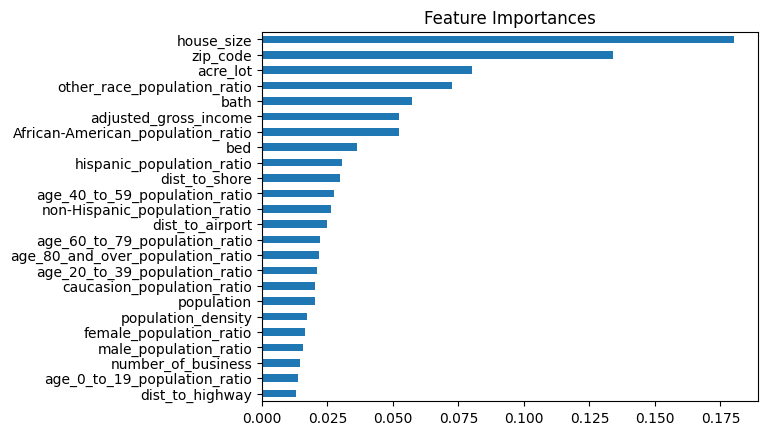

In [126]:
importances = rf.feature_importances_
feat_importance = pd.Series(importances, index=features.columns)
feat_importance.sort_values().plot(kind='barh', title="Feature Importances")
plt.show()


##4.5 Neural Network, stochastic gradient descent classification

###Create and Train the Neural Network

In [ ]:
model = MLPClassifier(hidden_layer_sizes=(64, 32),  # two hidden layers
                      activation='relu',
                      solver='adam',
                      max_iter=500,
                      random_state=42,
                      early_stopping=True)

model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)


###Evaluate the Model

In [ ]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


* Overall Presion: Very few false positives

* Overall Recall: High sensitivity

* Overall F1-Score: Excellent overall

* Accuracy: 0.91 High Accuracy Result

* Confusion Matrix:
1. True Negatives (TN): 17,484

2. False Positives (FP): 1,577

3. False Negatives (FN): 1,841

4. True Positives (TP): 16,668

5. Very balanced and low classification error.



##4.6 Comparison between different classification Models used

 Top Performer: Both Random Forest and Neural Network perform best (~91% accuracy).

Logistic Regression lags slightly behind, which makes sense given it's a linear model and may not capture complex relationships as well as RF or NN.

## 4.7 PCA to Reduce Dimensionality

In [ ]:
# 1. Fit PCA to the training data to analyze variance
pca = PCA()
pca.fit(X_train_scaled)
explained_variance = pca.explained_variance_ratio_

# 2. Plot cumulative explained variance
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(explained_variance)+1), explained_variance.cumsum(), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.axhline(y=0.80, color='r', linestyle='--', label='80% Explained Variance Threshold')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()




In [ ]:
# 3. Choose number of components (e.g., 15 based on plot or 95% variance)
pca = PCA(n_components=9)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

We are doing regressions without PCA since originally we tried with doing with PCA which resulted a lower performance in different regression models.

## 4.8 Data Preprocessing for Regressions

### Select features and target

In [ ]:
# Select meaningful features for training
features = real_estate_df.drop(columns = ['price', 'is_expensive', 'city', 'county', 'state'])
target = real_estate_df['price']

### Train Test Split

In [ ]:
# Use scikit-learn's train_test_split function to split data for regression
# into train and test sets. The split should be 80-20 meaning 80% for training
# and rest for testing.
seed = 42
X_train, X_test, y_train, y_test = train_test_split(features, target,
                                                    test_size=0.2,
                                                    random_state= seed)

###Standardize the Data

In [ ]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

##4.9 Linear Regression

### Train the Linear Regression Model

In [ ]:
# Initialize the linear regression model
linear_regressor = LinearRegression()

# Fit the model on the PCA-transformed training data
linear_regressor.fit(X_train_scaled, y_train)


### Make Predictions

In [ ]:
# Make predictions on the test set
y_pred = linear_regressor.predict(X_test_scaled)


### Evaluate the Model

In [ ]:
# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R² Score:", r2)


MSE (12.58 billion): It's quite large in absolute terms, but this is expected when predicting house prices, which are typically in the hundreds of thousands.

MAE (84,684.94): On average, the model's prediction is off by about 84685. That could be acceptable or large depending on the price range the houses have (e.g., it’s ~8.5% error if median price is ~$1M).

R² Score (0.742): The Model explains ~74% of the variance — Similar project for predicting housing price achieves R² Score from 0.60 to 0.75. Our Model does a fair job.

##4.10 Ridge Regression

###Train Ridge Regression Model

In [ ]:
# Initialize the Ridge regression model with a regularization parameter (alpha)
ridge_regressor = Ridge(alpha=1.0)  # You can adjust alpha (the regularization strength)

# Fit the model on the PCA-transformed training data
ridge_regressor.fit(X_train_scaled, y_train)


###Make Predictions

In [ ]:
# Make predictions on the test set
y_pred_ridge = ridge_regressor.predict(X_test_scaled)


###Evaluate the Model

In [ ]:
# Calculate performance metrics
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print("Ridge Regression - Mean Squared Error (MSE):", mse_ridge)
print("Ridge Regression - Mean Absolute Error (MAE):", mae_ridge)
print("Ridge Regression - R² Score:", r2_ridge)


MSE (12.60 billion):
It's quite large in absolute terms, but this is expected when predicting house prices, which are typically in the hundreds of thousands.

MAE (84,935.51):
On average, the model's prediction is off by about 84935. That could be acceptable or large depending on the price range the houses have (e.g., it’s ~8.5% error if median price is ~$1M).

R² Score (0.741):
The model explains about 74.1% of the variance in housing prices.

In [ ]:
plt.scatter(y_test, y_pred_ridge)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Ridge Regression - True vs Predicted Values')
plt.show()


## 4.11 Lasso Regression

###Train Lasso Regression Model

In [ ]:
# Initialize the Lasso regression model with a regularization parameter (alpha)
lasso_regressor = Lasso(alpha=0.1)  # You can experiment with different alpha values

# Fit the model on the PCA-transformed training data
lasso_regressor.fit(X_train_scaled, y_train)


###Make Predictions

In [ ]:
# Make predictions on the test set
y_pred_lasso = lasso_regressor.predict(X_test_scaled)


###Evaluate the Model

In [ ]:
# Calculate performance metrics
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print("Lasso Regression - Mean Squared Error (MSE):", mse_lasso)
print("Lasso Regression - Mean Absolute Error (MAE):", mae_lasso)
print("Lasso Regression - R² Score:", r2_lasso)


The results of Lasso Regression are nearly identical to Ridge Regression.

---



##4.12 Random Forest Regression

###Train Random Forest Regression Model

In [ ]:
# Initialize model with default parameters and fit it on the training set
reg_rf = RandomForestRegressor(random_state=42)
reg_rf.fit(X_train, y_train)


###Make Predictions

In [ ]:
# Use the model to predict on the test set and save these predictions as `y_pred`
y_pred = reg_rf.predict(X_test)

###Evaluate the Model

In [ ]:
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

Mean Squared Error (MSE): 5.15 billion. This value seems large, but MSE is sensitive to the scale of the target variable (house prices), which are often in the hundreds of thousands. It's more useful to look at MAE and R².

Mean Absolute Error (MAE): ~49,330. On average, the predictions are off by about $49k, which is quite reasonable depending on the housing price range ~1M e.g..

R² Score: 0.894. Similar housing price prediction project with random forest model commonly achieve 0.80–0.92 R² Score. Our model does a fair job.

##4.13 Neural Network, stochastic gradient descent

### Select features and target

In [ ]:
# Log-transform Target
target_log = np.log1p(target)

### Train Test Split

In [ ]:
# Use scikit-learn's train_test_split function to split data for regression
# into train and test sets. The split should be 80-20 meaning 80% for training
# and rest for testing.
X_train, X_test, y_train, y_test = train_test_split(features, target_log, test_size=0.2, random_state=42)

### Standardize the Data

In [ ]:
# Scale Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

###Train Neural Network model

In [ ]:
model = MLPRegressor(hidden_layer_sizes=(64, 32),
                     activation='relu',
                     solver='sgd',
                     learning_rate_init=0.01,
                     max_iter=1000,
                     early_stopping=True,
                     random_state=42)


In [ ]:
# Train the Model
model.fit(X_train_scaled, y_train)

###Make Predictions

In [ ]:
# Predict & Inverse Log Transform
y_pred_log = model.predict(X_test_scaled)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

###Evaluate the Model

In [ ]:
# Evaluate
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")


MSE: ~6.36 billion

Slightly higher than the Random Forest (~5.15 billion), but still solid for house price prediction.

MAE: ~$56,024

On average, the predictions are off by 56k. That’s reasonably close, though slightly worse than the RF model ($49k MAE).

R² Score: 0.869. Similar project predicting housing price with neural network R² can range from 0.82 to 0.90+. Our model does a fair job.

##4.14 Comparison of different Regression models used

Best Performer:
Random Forest Regression shows highest accuracy (highest R², lowest MSE & MAE), making it the best model overall.

Neural Network:
Performs quite well and can improve with hyperparameter tuning, but still lags slightly behind Random Forest.

Linear Models (Linear, Ridge, Lasso):
Much worse performance, likely due to the inability to capture non-linear relationships in the data. Ridge and Lasso offer only minor improvements through regularization.

## 4.15 K Means clustering

###Find the Optimal Number of Clusters (Elbow Method)

In [ ]:
#   for k ranges from 2 to 10, fit on "features" to generate an elbow plot
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init=5, random_state=0)
    kmeans.fit(features)
    wcss = kmeans.inertia_
    plt.scatter(k, wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow Plot')
plt.show()

In [ ]:
# choose the best number of clusters (the elbow)
number_of_cluster = 5

### Apply K-Means with Chosen number of clusters

In [ ]:
# TO-DO: re-run the K-Means clustering with the best number of clusters, save the fitted model to `kmeans`
kmeans = KMeans(n_clusters= number_of_cluster, n_init= 5, random_state= 0)
kmeans.fit(features)

# 5.Description of Challenges / Obstacles Faced

## Data Sourcing Challenges

When collecting real estate data, we explored multiple sources such as Kaggle, Redfin, and Zillow. While some of the most up-to-date datasets required paid access, we opted for freely available data from Kaggle, which, although slightly outdated, includes real estate information from 2022. For demographic data, our goal was to obtain information from 2022; however, the most recent publicly available data we could access was from 2020. We assumed that demographic distributions across ZIP codes did not change significantly between 2020 and 2022. The initial datasets were highly skewed, so we experimented with several techniques to address this issue. Ultimately, we chose to apply the Interquartile Range (IQR) method to remove outliers and improve data balance.

## Data imbalance

Data imbalance refers to a situation where the number of instances in each class of a dataset is not roughly equal.

In our binary classification task using logistic regression, we initially defined Class 1 as the upper quantile of house sold prices and Class 0 as the rest. This approach led to a data imbalance issue. In such cases, accuracy can be misleading because the model may appear to perform well simply by favoring the majority class, while failing to learn meaningful patterns from the underrepresented minority class.

To address this, we redefined the classification criteria by labeling Class 1 as the top 50% of house sold prices and Class 0 as the bottom 50%, thereby creating a more balanced dataset. Additionally, we set class_weight="balanced" in our logistic regression model to further account for any residual imbalance during training.

We evaluated model performance using metrics that are more informative in the context of potential imbalance, including F1-score, recall, and the confusion matrix. After rebalancing, Class 0 had 19,061 samples, and Class 1 had 18,509 samples, resulting in a nearly even distribution.

# 6.Potential Next Steps / Future Direction

Our top-performing classification models are Random Forest and Neural Network, both achieving approximately 91% accuracy. To enhance classification insights, we plan to explore multi-class classification, categorizing properties into pricing tiers such as low, mid, and high-end.

For regression tasks, Random Forest Regression yielded the best results with an R² score of 0.894, indicating strong predictive power. To further improve performance, we aim to incorporate additional impactful features, such as school district ratings, neighborhood crime statistics, and proximity to amenities. We also plan to examine the influence of local economic indicators, tax policies, and interest rates on housing prices.

Looking ahead, we are interested in studying how property values evolve over time by integrating historical price trends and experimenting with time series forecasting models like ARIMA or LSTM.